In [1]:
import ftplib 
from pyhdf.SD  import SD, SDC
from pyhdf.V import *
from pyhdf.HDF import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import os
import glob
os.environ['PROJ_LIB'] = 'D:\\program\\anaconda3\\Library\\share\\'
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import pickle
import pprint
import gc 
import datetime
import bz2

#####Fuction for extracting variable names from hdf file
def HDFvars(File):
    hdfFile = SD(File, SDC.READ)
    dsets = hdfFile.datasets()
    k = []
    for key in dsets.keys():
        k.append(key)
    k.sort()
    hdfFile.end() # close the file
    return k
#####Function end

In [2]:
with open('cloudsat_cloud_info_1011_5type.pkl', 'rb') as f:
    clouds = pickle.load(f)
with open('cloudsat_cluster_info_1011_5type.pkl', 'rb') as f:
    hca = pickle.load(f)
typenum=5

In [3]:
#0 granual    1 julian     2 cloud num      3 lat           4 lon            5 size           6 top           7 bot                     8 landsea 
#9   0dbz mask          10  0dbz h            11  10dbz mask             12  10dbz h           13 max dBz           14 max h           
#15edge         16 edge           17 hori          18 system
print('Cloud object array:')
print(clouds.shape)

Cloud object array:
(113382, 19)


In [4]:
type_object=clouds[hca==2,:]
print(type_object.shape)
for i in range(4800,4801):
    print('cloud number',i)
    print('granul',type_object[i,0])
    print('julian day',type_object[i,1])
    print('lat   ',type_object[i,3])
    print('lon   ',type_object[i,4])
    print('top   ',type_object[i,6])
    print('bot   ',type_object[i,7])
    print('hori  ',type_object[i,17])
    print('edge1   ',type_object[i,15])
    print('edge2  ',type_object[i,16])

(4901, 19)
cloud number 4800
granul 49196.0
julian day 209.0
lat    18.68
lon    93.16
top    16620.0
bot    444.0
hori   954.0
edge1    7816.0
edge2   8769.0


In [5]:
granul=str(int(type_object[i,0]))
edge1=int(type_object[i,15])
edge2=int(type_object[i,16])
cen_lat=type_object[i,3]
cen_lon=type_object[i,4]
print(granul)
print(edge1)
print(edge2)
##
filepath = 'C:\\Users\\linnick\\Desktop\\cloudsat_ml\\'
##
path_len=len(filepath)
target_file=filepath+ '*_' + granul + '_*'+ '.hdf'
print(target_file)
files = glob.glob(target_file)
print(files)

49196
7816
8769
C:\Users\linnick\Desktop\cloudsat_ml\*_49196_*.hdf
['C:\\Users\\linnick\\Desktop\\cloudsat_ml\\2015209062758_49196_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf']


In [6]:
#for himarwari 
extrat_file=files[0]
object_year=extrat_file[path_len:path_len+4]
object_year=int(object_year)
object_julian_day=extrat_file[path_len+4:path_len+7]
object_julian_day=int(object_julian_day)
print(object_year)
print(object_julian_day)

himarwari_cal_date = datetime.datetime(object_year,1,1,0,0) + datetime.timedelta(object_julian_day - 1)
print(himarwari_cal_date)
himarwari_cal_date=str(himarwari_cal_date)

object_mon=himarwari_cal_date[5:7]
object_day=himarwari_cal_date[8:10]
print(object_mon)
print(object_day)

2015
209
2015-07-28 00:00:00
07
28


In [7]:
#以台灣為中心畫圖，所以要調整一下經度的表示方式
#mo_longitude=np.asarray(longitude)
#shape1 = mo_longitude.shape

#for i in range(0,shape1[0]):
 #   if mo_longitude[i] < -60:
 #       mo_longitude[i]=mo_longitude[i]+360

In [8]:
#fig = plt.figure(figsize=(16,12)) 
#m = Basemap(llcrnrlon=-60, urcrnrlon=300., llcrnrlat=-90., urcrnrlat=90.,resolution='l')
#m.drawcoastlines(linewidth=0.5)
#m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0])
#m.drawmeridians(np.arange(-180., 181., 30.), labels=[0, 0, 0, 1])
#m.scatter(mo_longitude[:], latitude[:] , c=MODIS_cloud_fraction[:] ,cmap=plt.cm.get_cmap('jet',10), vmin=10, vmax=120)
#plt.show()

In [9]:
#filename = '2015209062758_49196_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf'
#讀取vdata
reading_vdata = HDF(files[0], HC.READ).vstart()
vdata =reading_vdata.vdatainfo()

#pprint.pprint(vdata[:])##把vdata存的變數名稱輸出
members = [7 ,  8 , 10, 11, 18 ,31 ,38] ##我們想提出的geolocation data
nrecs = []
names = []
for ref in members:
 #       # Vdata tag
    vd = reading_vdata.attach(ref)
    nrecs.append(vd.inquire()[0])  ## number of records of the Vdata
    names.append(vd.inquire()[-1]) ## name of the Vdata
    vd.detach()

print(names)##輸出的變數名稱
print(nrecs)##變數矩陣的長度

# Read geolocation dataset.
#['UTC_start', 'Latitude', 'Longitude', 'Data_quality', 'MODIS_Cloud_Fraction','Navigation_land_sea_flag']
idx = names.index('Profile_time')
var = reading_vdata.attach(members[idx])
profile_time = var.read(nrecs[idx])

idx = names.index('UTC_start')
var = reading_vdata.attach(members[idx])
UTC_time = var.read(nrecs[idx])

idx = names.index('Latitude')
var = reading_vdata.attach(members[idx])
latitude = var.read(nrecs[idx])

idx = names.index('Longitude',)
var = reading_vdata.attach(members[idx])
longitude = var.read(nrecs[idx])

idx = names.index('MODIS_Cloud_Fraction',)
var = reading_vdata.attach(members[idx])
MODIS_cloud_fraction = var.read(nrecs[idx])

idx = names.index('Data_quality',)
var = reading_vdata.attach(members[idx])
data_quality = var.read(nrecs[idx])

del reading_vdata
print(gc.collect())

['Profile_time', 'UTC_start', 'Latitude', 'Longitude', 'Data_quality', 'MODIS_Cloud_Fraction', 'Navigation_land_sea_flag']
[20678, 1, 20678, 20678, 20678, 20678, 20678]
0


In [10]:
# Read dataset.
hdfFile = SD(files[0], SDC.READ)##SDS資料輸出
Reflectivity = hdfFile.select('Radar_Reflectivity')##輸出變數
Cloud_mask = hdfFile.select('CPR_Cloud_mask')
Height = hdfFile.select('Height')
pprint.pprint(Reflectivity.attributes())##輸出變數的基本資料

{'_FillValue': 15360}


In [11]:
print(Reflectivity[0:10])

[[-8888 -3399 -2781 ... 16876 16876 16876]
 [-8888 -3359 -8888 ... 16876 16876 16876]
 [-3279 -2584 -3317 ... 16876 16876 16876]
 ...
 [-2938 -8888 -8888 ... 16876 16876 16876]
 [-8888 -3254 -8888 ... 16876 16876 16876]
 [-3584 -2612 -8888 ... 16876 16876 16876]]


In [134]:
outbond=int(np.ceil((edge2-edge1)/20))
print(outbond)
event_Reflectivity=Reflectivity[edge1-outbond:edge2+outbond,:]/100
event_height=Height[edge1-outbond:edge2+outbond,:]
event_cloud_mask= Cloud_mask[edge1-outbond:edge2+outbond,:]
event_height=Height[edge1-outbond:edge2+outbond,:]
event_lat=latitude[edge1-outbond:edge2+outbond]
forcen_lat=event_lat
event_lon=longitude[edge1-outbond:edge2+outbond]
print(event_Reflectivity.shape)
print(event_lat[0])
print(event_lat[952])

48
(1049, 125)
[13.629298210144043]
[22.820680618286133]


In [52]:
track_mask=np.zeros(nrecs[0])
track_lon=np.zeros(nrecs[0])
track_lat=np.zeros(nrecs[0])
mo_longitude=np.asarray(longitude)
mo_latitude=np.asarray(latitude)
for i in range(0,nrecs[0]):
    track_lon[i]=mo_longitude[i]
    track_lat[i]=mo_latitude[i]
print(track_mask[0:15])
track_mask[edge1-1:edge2]=1


print(longitude[0:15])

print(track_mask[edge1-1:edge1+20])
print(track_lon[0:15])
#print(track_mask.shape)
#print(len(MODIS_cloud_fraction))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[116.28541564941406], [116.27901458740234], [116.27261352539062], [116.26622009277344], [116.25983428955078], [116.25346374511719], [116.24708557128906], [116.24070739746094], [116.23432922363281], [116.22795104980469], [116.2215805053711], [116.21522521972656], [116.20886993408203], [116.20250701904297], [116.19615173339844]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[116.28541565 116.27901459 116.27261353 116.26622009 116.25983429
 116.25346375 116.24708557 116.2407074  116.23432922 116.22795105
 116.22158051 116.21522522 116.20886993 116.20250702 116.19615173]


In [53]:
print(UTC_time[0])
print(profile_time[edge1:edge1+10])
object_time=np.asarray(UTC_time[0])+profile_time[edge1]
hour=object_time/3600
print(hour)
object_min=int(np.around(60*(hour-int(hour)),-1))
object_hour=int(hour)

#####
if object_min == 60:
    object_min=0
    object_hour=object_hour+1
#print(object_hour)
#####
if object_hour < 10:
    str_object_hour="0" + str(object_hour)
else:
    str_object_hour=str(object_hour)
#####
if object_min < 10:
    str_object_min="0" + str(object_min)
else:
    str_object_min=str(object_min)

print(object_min)
print(object_hour)
himarwari_time= str_object_hour + str_object_min
print(himarwari_time)

[25232.50390625]
[[1250.56005859375], [1250.719970703125], [1250.8800048828125], [1251.0400390625], [1251.199951171875], [1251.3599853515625], [1251.52001953125], [1251.6800537109375], [1251.8399658203125], [1252.0]]
[7.35640666]
20
7
0720


In [120]:
user     = "anonymous"
password = "anonymous"
ftp =  ftplib.FTP('hmwr829gr.cr.chiba-u.ac.jp')
ftp.login(user, password)

'230 Anonymous ã\x82¢ã\x82¯ã\x82»ã\x82¹ã\x81\x8cè¨±å\x8f¯ã\x81\x95ã\x82\x8cã\x81¾ã\x81\x97ã\x81\x9f  ã\x81\x9fã\x81\xa0ã\x81\x97ã\x80\x81ä½¿ç\x94¨å\x88¶é\x99\x90ã\x81\x8cé\x81©ç\x94¨ã\x81\x95ã\x82\x8cã\x81¾ã\x81\x99'

In [121]:
filedate=str(object_year) + object_mon
titlename = str(object_year) +'/'+ object_mon +'/'+ object_day +' '+ str_object_hour +':'+ str_object_min
#
filedate_str=str(filedate)
filepath='/gridded/FD/V20151105/' + filedate_str +'/TIR/'
print(filepath)
ftp.cwd(filepath) #設定FTP當前操作的路徑
himarwari_date=filedate_str + object_day + himarwari_time + '*'
print(himarwari_date)
#ftp.dir(himarwari_date) #顯示目錄下檔案
file = ftp.nlst(himarwari_date+'*.tir.09.*bz2')
print(file)
with open(file[0], 'wb') as fp:
    ftp.retrbinary('RETR ' +  file[0],fp.write)

/gridded/FD/V20151105/201507/TIR/
201507280720*
['201507280720.tir.09.fld.geoss.bz2']


In [56]:
##on work station
#cmd= 'bunzip2 ' + file[0]
#print(cmd)
#os.system(cmd)

##on personal computer
import subprocess
filepath = 'C:\\Users\\linnick\\Desktop\\cloudsat_ml\\' + file[0]  
testt = 'C:\\Program Files\\7-Zip\\7z.exe e  '  + filepath
print(testt)
subprocess.call(testt)

C:\Program Files\7-Zip\7z.exe e  C:\Users\linnick\Desktop\cloudsat_ml\201507280720.tir.09.fld.geoss.bz2


2

In [57]:
unzip_file = glob.glob(himarwari_date + '*.tir.09.*.geoss')
print(unzip_file)
tem_tir = np.fromfile(unzip_file[0] ,dtype='>u2')
print(tem_tir.size)
print(tem_tir[0:10])

['201507280720.tir.09.fld.geoss']
36000000
[3637 3637 3637 3645 3645 3645 3645 3655 3655 3633]


In [58]:
convt=np.loadtxt('tir.09')
convt_num=convt[:,0]
convt_num=convt_num.astype(int)
convt_tbb=convt[:,1]
print(convt_tbb[5])
print(convt_num[0:5])
print(convt_tbb[convt_num[5]])

330.724384
[0 1 2 3 4]
330.724384


In [59]:
tem_tir_map  = tem_tir.reshape((6000,6000))
r_tem_tir_map = tem_tir_map[::-1]

In [60]:
#tri_tbb_map = np.zeros((6000,6000))
#for i in range(0,6000):
#    for j in range(0,6000):
#        tri_tbb_map[i,j]=convt_tbb[tem_tri_map[i,j]]

In [61]:
x = np.arange(85.01,205.01,0.02)
y = np.arange(-59.99,60.01,0.02)
region_mask_lat = np.zeros((6000))
region_mask_lon = np.zeros((6000))
edgelat1=cen_lat-15
edgelat2=cen_lat+15
edgelon1=cen_lon-15
edgelon2=cen_lon+15
region_mask_lon[(x>=edgelon1) & (x<=edgelon2)]=1
region_mask_lat[(y>=edgelat1) & (y<=edgelat2)]=1
region_lon=x[(x>=edgelon1) & (x<=edgelon2)]
region_lat=y[(y>=edgelat1) & (y<=edgelat2)]
where_nozero_lat=np.nonzero(region_mask_lat)
where_nozero_lon=np.nonzero(region_mask_lon)
start_lat=where_nozero_lat[0]
start_lon=where_nozero_lon[0]
print(start_lat[0])
print(x.shape)

3184
(6000,)


In [62]:

tbb_region = np.zeros((int(sum(region_mask_lat)),int(sum(region_mask_lon))))

print(region_lon[0:10])

[85.01 85.03 85.05 85.07 85.09 85.11 85.13 85.15 85.17 85.19]


In [63]:
for i in range(0,6000):
    for j in range(0,6000):
        if region_mask_lat[i] > 0 and region_mask_lon[j] > 0:
            tbb_region[i-start_lat[0],j-start_lon[0]] =convt_tbb[r_tem_tir_map[i,j]]

In [64]:
print(tbb_region.shape)
print(region_lon[0:10])
print(region_lat[0:10])

(1500, 1158)
[85.01 85.03 85.05 85.07 85.09 85.11 85.13 85.15 85.17 85.19]
[3.69 3.71 3.73 3.75 3.77 3.79 3.81 3.83 3.85 3.87]


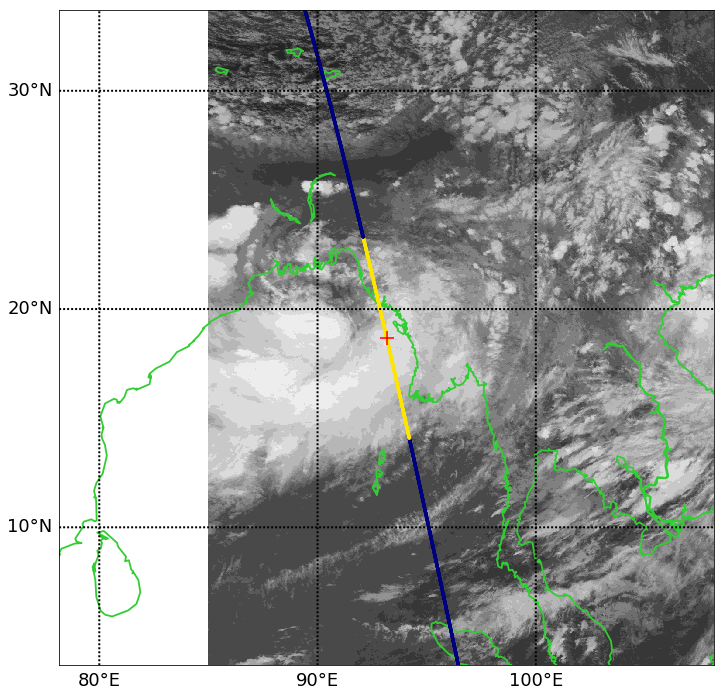

In [117]:
fig = plt.figure(figsize=(10,10)) 
m = Basemap(llcrnrlon=cen_lon-15, urcrnrlon=cen_lon+15, llcrnrlat=cen_lat-15, urcrnrlat=cen_lat+15,resolution='l')
m.drawcoastlines(linewidth=1.8,color='limegreen')
    #m.drawparallels(np.arange(-100., 120., 25.), labels=[1, 0, 0, 0])
m.drawparallels(np.arange(-100., 120., 10.), labels=[1, 0, 0, 0], linewidth=2.0, color='k', fontsize=18)
m.drawmeridians(np.arange(-180., 171., 10.), labels=[0, 0, 0, 1], linewidth=2.0, color='k', fontsize=18)

#print(x.shape)
cmap2 = cm.get_cmap("gray_r",lut=15)
cmap2.set_under("white")
#r_tri_tbb_region = tri_tbb_region[::-1]

m.pcolormesh(region_lon,region_lat,tbb_region,cmap=cmap2,vmin=180,vmax=330)
m.scatter(track_lon[:], track_lat[:],s=5 , c=track_mask[:] ,cmap=plt.cm.get_cmap('jet',10), vmin=0, vmax=1.6, zorder=2)
m.scatter(cen_lon, cen_lat,marker='+',s=180 , color='red', zorder=2)
plt.tight_layout()

In [135]:
print(event_Reflectivity.shape)
Ref= event_Reflectivity[:,:].T
r_Ref = Ref[::-1]
c_mask=event_cloud_mask[:,:].T
r_c_mask = c_mask[::-1]
Hef= event_height[:,:].T
r_Hef = Hef[::-1]
ref_height=np.mean(r_Hef,axis=1)
ref_height=np.around(ref_height)
event_lat = np.around(event_lat,decimals=1)

(1049, 125)


In [ ]:
cmap = mpl.cm.jet(np.linspace(0,1,170))
cmap = mpl.colors.ListedColormap(cmap[15:155])

In [172]:
###find object geolocation postition
index = (np.abs(forcen_lat-cen_lat)).argmin()
cloud_geo = index/(edge2-edge1+(outbond*2))
index_height = (np.abs(ref_height[:,]-10000)).argmin()

print(ref_height[62])
aaaa=ref_height[16:105]
print(y_values.shape)
index_height = (np.abs(aaaa-10000)).argmin()
test=np.zeros((89,1049))
test[0:index_height+1,:]=1

10068.0
(89, 1049)


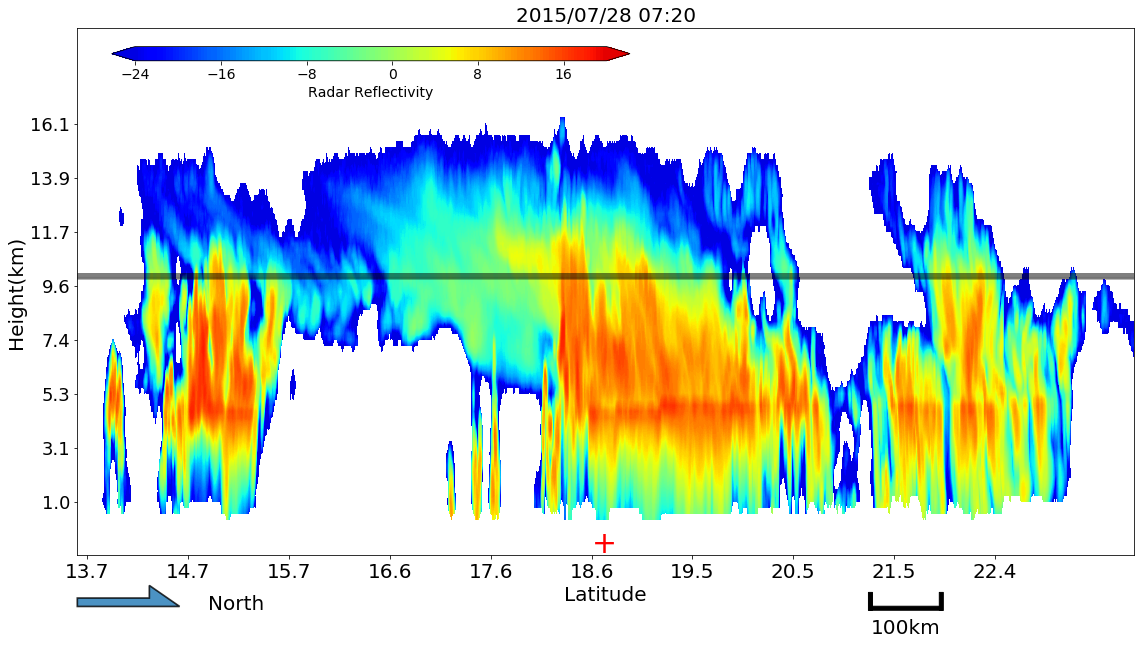

In [180]:
#雷達回波 plot
fig = plt.figure(figsize=(16,9)) 
#a = np.array([[-25:20,2]])
#print(a)
levels = np.linspace(-24,20,150)

#norm = cs.BoundaryNorm(a[0], len(a[0])-1)
y_values = np.ma.array(r_Ref[16:105,:])
mask=np.ma.array(r_c_mask[16:105,:])
#mask values below a certain threshold
y_values_masked = np.ma.masked_where(mask < 20 , y_values)
plt.contour(test,colors='k',linewidths=0.5)
plt.contourf(y_values_masked,levels=levels,cmap=cmap,extend='both')

#plt.scatter(500, 2,marker='+',s=180 , color='red', zorder=2)
#plt.clim(-25, 20);


####比例尺設定 
scale_100km=71.43
spost=0.75
elen=71.43/(edge2-edge1+(outbond*2))
bopost=elen/130
bot=-.1
plt.annotate('100km', xy=(spost+elen/2, -.12),xycoords='axes fraction',fontsize=20, ha="center", va="top")
plt.annotate('', xy=(spost, bot),xycoords='axes fraction',xytext=(spost+elen, bot),fontsize=50, arrowprops=dict(width=4,headwidth=0,headlength=0.00001, color='k'))
plt.annotate('', xy=(spost+bopost,bot-0.0042),xycoords='axes fraction',xytext=(spost+bopost, bot+0.03),fontsize=50, arrowprops=dict(width=4,headwidth=0,headlength=0.00001, color='k'))
plt.annotate('', xy=(spost+elen-bopost, bot-0.0042),xycoords='axes fraction',xytext=(spost+elen-bopost, bot+0.03),fontsize=50, arrowprops=dict(width=4,headwidth=0,headlength=0.00001, color='k'))
####方向指示
plt.arrow(0,-8.5,scale_100km,0,width=2.8,shape='right' ,linewidth=1.7,head_length=30,head_width=7,alpha=0.8,clip_on=False)
plt.annotate('North', xy=(0.15, -.075),xycoords='axes fraction',fontsize=20, ha="center", va="top")

####cloud features
#plt.annotate('', xy=(0, bot),xycoords='axes fraction',xytext=(spost+elen, bot),fontsize=50, arrowprops=dict(width=4,headwidth=0,headlength=0.00001, color='k'))
plt.annotate('+', xy=(cloud_geo, 0.05),xycoords='axes fraction',color='red',fontsize=30, ha="center", va="top")
####

plt.title(titlename,size=20)
#XY軸設定指令
aa=np.around(ref_height[24:95:9,]/1000,1)
plt.yticks(np.arange(9,75,step=9), aa)
##
plt.xticks(np.arange(10,950,step=100), (event_lat[10:950:100,0]))
##
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=18)
plt.ylabel('Height(km)',color='k',fontsize=20)
plt.xlabel('Latitude',color='k',fontsize=20)
cax = fig.add_axes([0.1, 0.9, 0.45, 0.022])
v = np.linspace(-24,16,6)
cb = plt.colorbar(cax=cax,aspect=10,ticks=v,orientation='horizontal')
cb.ax.tick_params(labelsize=14)
cb.set_label('Radar Reflectivity', size=14)

plt.tight_layout()
#plt.savefig('121addscale_sample_type0_9057.pdf')